In [1]:
import numpy as np
import numpy.fft as fft
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import random
from collections import defaultdict
from numpy import hamming
import os
import pickle

In [2]:
PATH = '../WESAD/'
SUBJECTS = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '13', '14', '15', '16', '17']
CHEST_SIGNALS = ['ECG', 'EMG', 'EDA', 'Resp', 'Temp', 'ACC']
CHEST_SAMPLING_RATE = 700

In [3]:
def read_subject_data(subject) :
    path = PATH + 'S' + subject + '/S' + subject + '.pkl'
    subject = pd.read_pickle(path)
    
    return subject

In [4]:
def visualize_raw(signal, duration, sampling_rate, title) :
    n = duration * sampling_rate
    l = len(signal)
    
    s = random.randint(0, l - n)
    df = pd.DataFrame(columns=['x', 'y'])
    df['x'] = np.arange(n)
    df['y'] = signal[s:s+n]
    
    plt.figure(figsize=(20, 5))
    sns.scatterplot(x = 'x', y = 'y', data = df, s = 3).set(title=title)

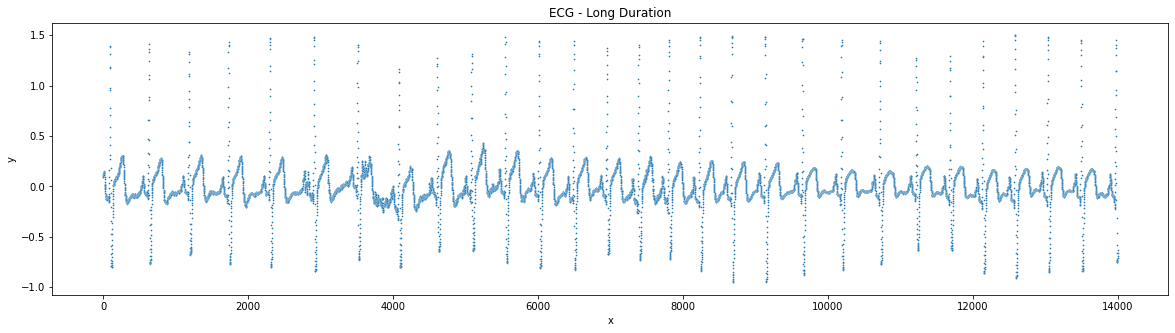

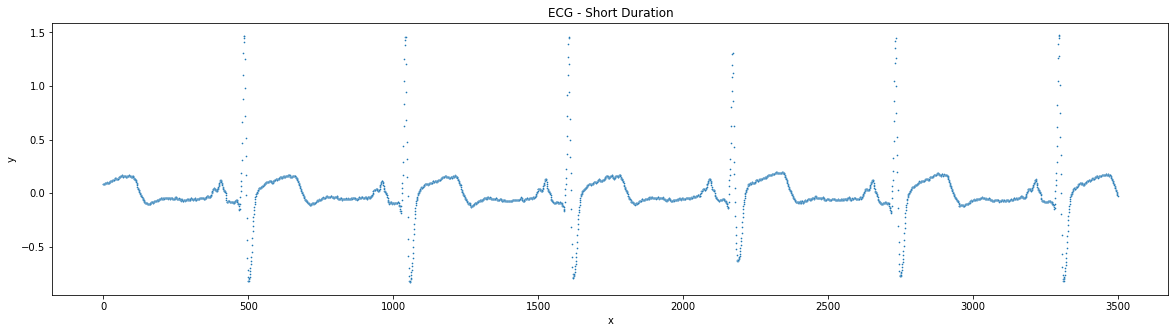

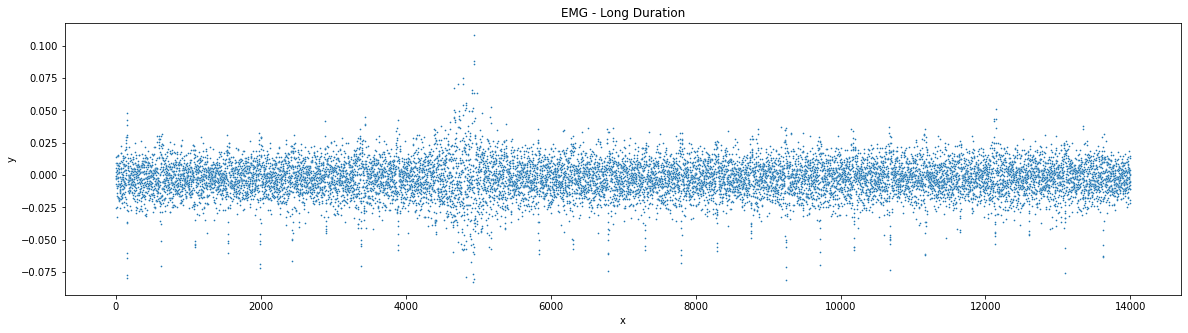

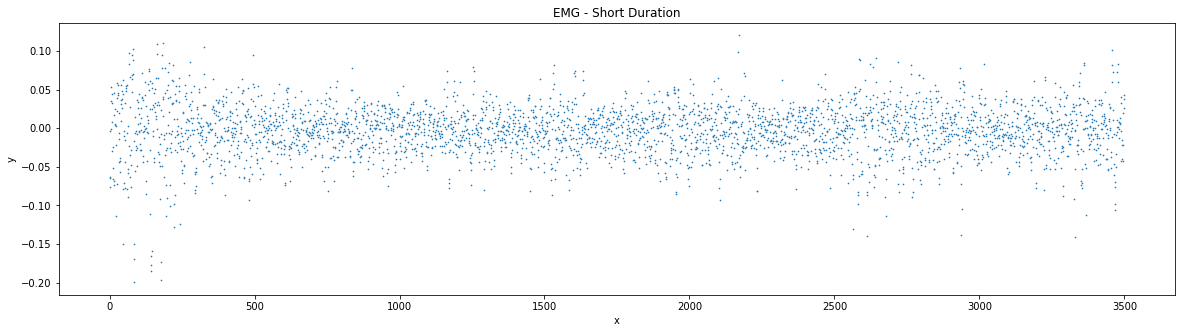

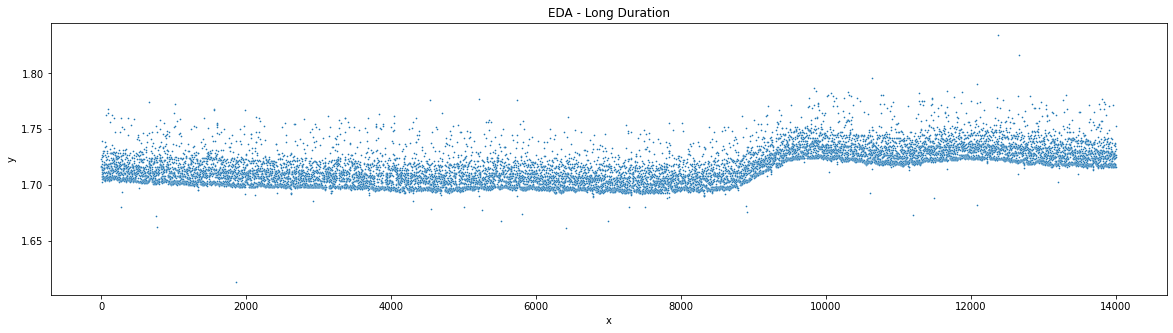

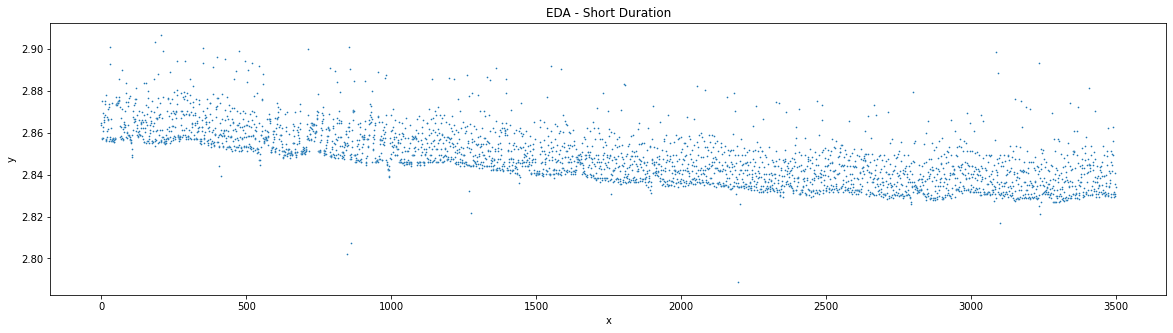

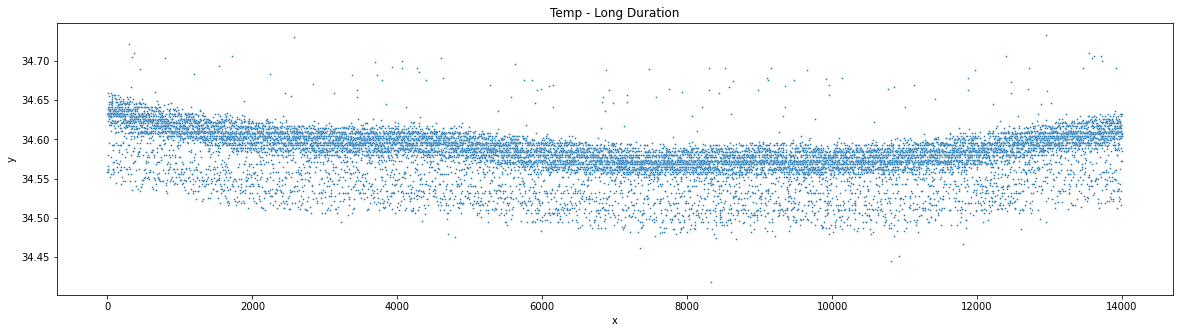

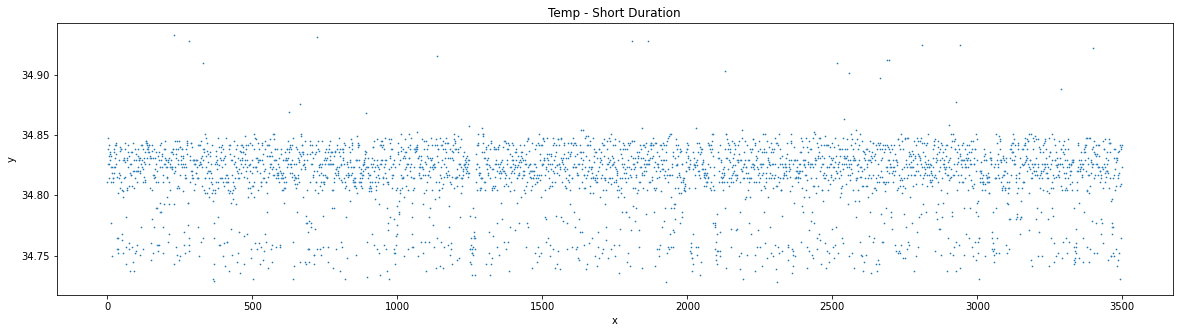

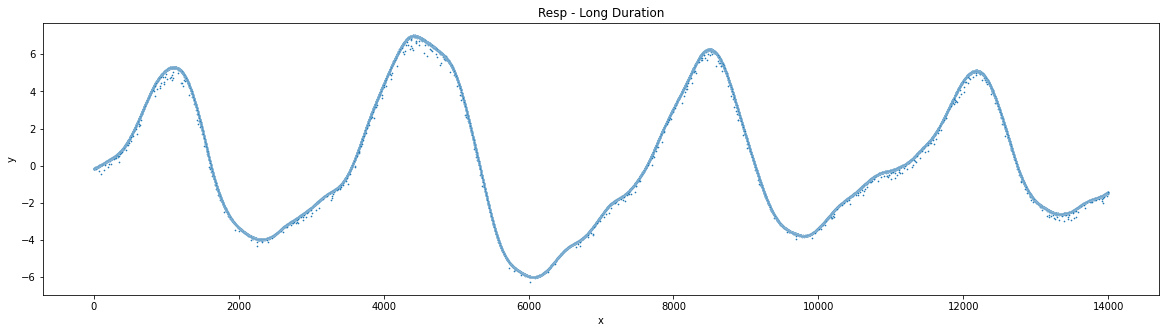

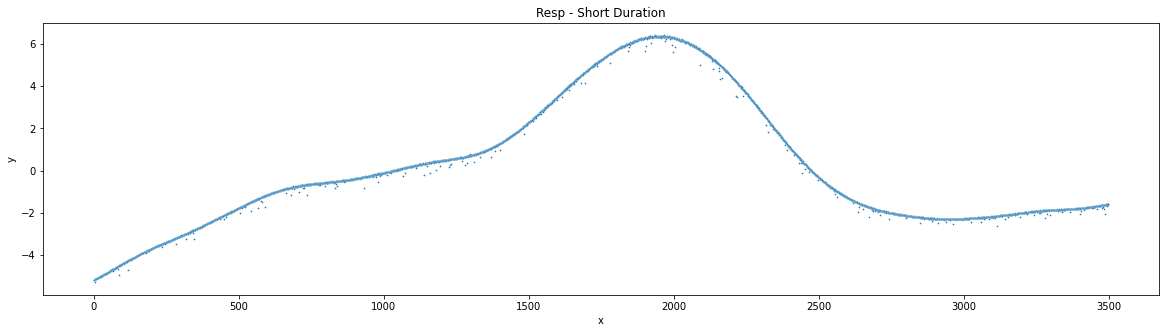

In [5]:
# Visualize the different chest signals for a random subject

SAMPLING_RATE = 700
LONG_DURATION = 20
SHORT_DURATION = 5

subject = random.choice(SUBJECTS)
subject_data = read_subject_data(subject)

chest_signals = subject_data['signal']['chest']

for signal_type in chest_signals :
    if signal_type == 'ACC' :
        continue
    
    signal = chest_signals[signal_type]
    visualize_raw(signal, LONG_DURATION, SAMPLING_RATE, signal_type + ' - Long Duration')
    visualize_raw(signal, SHORT_DURATION, SAMPLING_RATE, signal_type + ' - Short Duration')

In [6]:
# https://imotions.com/blog/eda/
# https://www.scitepress.org/Papers/2021/102446/102446.pdf
# https://sci-hub.ee/10.1016/j.cmpb.2020.105482
WINDOW_LEN = 20
OVERLAP = 0.75
NUM_FEATURES = 10

In [7]:
# Identify the continuous intervals for each label
def find_intervals(labels) :
    intervals = []

    l = len(labels)
    i = 0
    label = labels[0]

    for j in range(l):
        if label != labels[j]:
            intervals.append({
                'label' : label, 
                'beg' : i,
                'end' : j
                })
            i = j
            label = labels[j]

    intervals.append({
        'label' : label, 
        'beg' : i,
        'end' : l
    })

    return intervals    

In [8]:
def extract_fft_features(signal, num_features) :
    window = hamming(len(signal))
    signal *= window
    coeffs = fft.fft(signal)
    l = len(coeffs)
    freqs = fft.fftfreq(l)
    
    # Discard the negative elems
    l //= 2
    amps = np.abs(coeffs[0:l])
    freqs = np.abs(freqs[0:l])
    
    # Sort descending w.r.t amp   
    p = amps.argsort()[::-1]
    freqs = freqs[p]
    amps = amps[p]
    
    features = [[amps[i], freqs[i]] for i in range(num_features)]    
    return np.array(features)

In [9]:
def normalize_fft_features(train_features, test_features) :
    feature_mean = np.mean(train_features, axis=0)
    feature_std = np.std(train_features, axis=0)
    train_features -= feature_mean
    test_features -= feature_mean
    train_features = np.divide(train_features, feature_std, out=np.zeros_like(train_features), where=feature_std!=0)
    test_features = np.divide(test_features, feature_std, out=np.zeros_like(test_features), where=feature_std!=0)
    
    return train_features, test_features

In [10]:
TRANSIENT = 0
BASELINE = 1
STRESS = 2
AMUSEMENT = 3
MEDITATION = 4
IGNORE = 5

def extract_signal_features(signal, intervals, sampling_rate, window_len = WINDOW_LEN, overlap = OVERLAP, num_features = NUM_FEATURES) :
    segment_size = sampling_rate * window_len
    signal_features = {
        BASELINE : [],
        STRESS : [],
        AMUSEMENT : [],
        MEDITATION : []
    }
    
    baseline_av = 0
    
    for interval in intervals :
        label = interval['label']
        beg = interval['beg']
        end = interval['end']
        
        signal_of_interest = signal[beg:end]  
        
        if label >= IGNORE or label == TRANSIENT:
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
            continue      
            
        if label == BASELINE :
            baseline_av = (np.mean(signal_of_interest) + baseline_av)/2
        
        signal_of_interest -= baseline_av
        
        l = end - beg        
        while l >= segment_size:
            segment = signal_of_interest[int(l - segment_size) : l]
            l -= int((1 - overlap) * segment_size)
            
            segment_features = extract_fft_features(segment, num_features)            
            signal_features[label].append(segment_features)
        
    return signal_features

In [11]:
def get_chest_signal_dataset(subjects, signal_type) :
    dataset = defaultdict(list)
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
        
        signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
        
        for label, feature_vecs in signal_features.items() :
            dataset[label] += list(feature_vecs)
            
    features_dataset = [] 
    label_dataset = []
    
    for label, feature_vecs in dataset.items() :
        for features in feature_vecs :
            features_dataset.append(features)
            label_dataset.append(label)

    return np.array(features_dataset), np.array(label_dataset)

In [12]:
# Get Joint test-train  Datasets combining all signals

def get_agg_chest_signal_dataset(subjects) :
    agg_feature_dataset = []
    agg_labels_dataset = []
    
    for subject in subjects :
        subject_data = read_subject_data(subject)
        intervals = find_intervals(subject_data['label'])
        
        subject_agg = {
            BASELINE : [],
            STRESS : [],
            AMUSEMENT : [],
            MEDITATION : []
        }
        
        for signal_type in CHEST_SIGNALS :
            if signal_type == 'ACC' :
                continue
                
            signal = np.array(subject_data['signal']['chest'][signal_type]).flatten()
            signal_features = extract_signal_features(signal, intervals, CHEST_SAMPLING_RATE)
            
            for label, features in signal_features.items() :
                subject_agg[label].append(features)
                
        for label in subject_agg :
            subject_agg[label] = np.stack(subject_agg[label], axis = 1)
            
        for label, feature_aggs in subject_agg.items() :
            for feature_agg in feature_aggs :
                agg_feature_dataset.append(feature_agg)
                agg_labels_dataset.append(label)

    return agg_feature_dataset, agg_labels_dataset

In [13]:
# Visualize Datasets
def visualize_dataset(features, labels) :
    features = np.array(features)
    amps = np.log10(features[:, :, 0].flatten())
    freqs  = features[:, :, 1].flatten()
    labels = np.repeat(np.array(labels), NUM_FEATURES)
    
    df = pd.DataFrame()
    df['Amp'] = amps
    df['Freq'] = freqs
    df['Label'] = labels
    
    for label, group in df.groupby('Label') :
        plt.figure(figsize=(20, 20))
        sns.scatterplot(x = 'Freq', y = 'Amp', data = group, palette='bright').set(title=label)
    
    plt.figure(figsize=(20, 20))
    sns.scatterplot(x = 'Freq', y = 'Amp', hue = 'Label', style='Label', data = df, palette='bright')

In [14]:
def encode_labels(labels) :
    encoder = {
        1 : [1, 0, 0, 0],
        2 : [0, 1, 0, 0],
        3 : [0, 0, 1, 0],
        4 : [0, 0, 0, 1]
    }
    
    return np.array([np.array(encoder[l]) for l in labels])

In [15]:
# Get additional notes for the Subjects

for subject in SUBJECTS :
    with open(PATH + 'S' + subject + '/S' + subject + '_readme.txt', 'r') as file :
        print(subject, file.readlines()[16])

2 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.

3 During the baseline condition, the subject was sitting in a sunny workplace.

4 -

5 Subject might have fallen asleep during the first meditation.

6 Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

7 -

8 Subject had already a rather stressful day, prior to the study.

9 -

10 -

11 -

13 -

14 -

15 Subject didn't really believe the cover story of the stress condition (TSST).

16 Subject felt rather cold in the room where the stress condition was carried out.

17 The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.



In [24]:
# Get ECG Test-Train Datasets

# test_subjects = ['9', '10']
# train_subjects = ['2', '3', '4', '5', '6', '7', '8', '11', '13', '14', '16', '15', '17']

test_subjects = ['2']
train_subjects = [ '9', '15', '3', '4', '5', '6', '7', '8', '11', '13', '14', '16', '10', '17']

train_features, train_labels = get_agg_chest_signal_dataset(train_subjects)
test_features, test_labels = get_agg_chest_signal_dataset(test_subjects)
train_features, test_features = normalize_fft_features(train_features, test_features)

In [25]:
train_labels = encode_labels(train_labels)
test_labels = encode_labels(test_labels)

In [26]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(5, 10, 2)),
    keras.layers.Conv2D(4, kernel_size=(1,2), activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(8, kernel_size=(1,2), strides=(1, 2), activation='swish'),
    keras.layers.Conv2D(6, kernel_size=(2,2), activation='swish'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(4, kernel_size=(2,2), activation='swish'),
    keras.layers.Conv2D(2, kernel_size=(1,2), activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=10,  activation='swish'),
    keras.layers.Dense(units=8,  activation='swish'),
    keras.layers.Dense(units=4, activation='swish')
])

# 0.9521 val_accuracy: 0.8915

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 5, 9, 4)           20        
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 9, 4)           16        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 4, 8)           72        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 3, 6)           198       
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 3, 6)           24        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 2, 4)           100       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 1, 2)          

In [28]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=tf.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [29]:
print(np.shape(train_features), np.shape(train_labels), np.shape(test_features), np.shape(test_labels))

(8181, 5, 10, 2) (8181, 4) (561, 5, 10, 2) (561, 4)


In [30]:
model.fit(train_features, train_labels, epochs=10000, batch_size = 16, verbose=1, shuffle=True,
              validation_data=(test_features,  test_labels), callbacks=[])

Epoch 1/10000
512/512 [==============================] - 1s 2ms/step - loss: 1.3781 - accuracy: 0.3207 - val_loss: 1.3706 - val_accuracy: 0.3886
Epoch 2/10000
512/512 [==============================] - 1s 1ms/step - loss: 1.3519 - accuracy: 0.3971 - val_loss: 1.3440 - val_accuracy: 0.4011
Epoch 3/10000
512/512 [==============================] - 1s 1ms/step - loss: 1.3186 - accuracy: 0.4004 - val_loss: 1.3017 - val_accuracy: 0.4011
Epoch 4/10000
512/512 [==============================] - 1s 1ms/step - loss: 1.2453 - accuracy: 0.4279 - val_loss: 1.2172 - val_accuracy: 0.4100
Epoch 5/10000
512/512 [==============================] - 1s 1ms/step - loss: 1.0667 - accuracy: 0.5908 - val_loss: 1.1195 - val_accuracy: 0.4385
Epoch 6/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.8312 - accuracy: 0.7041 - val_loss: 1.0100 - val_accuracy: 0.5401
Epoch 7/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.7259 - accuracy: 0.7143 - val_loss: 0.9645 - val_ac

512/512 [==============================] - 1s 1ms/step - loss: 0.2679 - accuracy: 0.9029 - val_loss: 1.5849 - val_accuracy: 0.6453
Epoch 58/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2620 - accuracy: 0.9049 - val_loss: 1.7499 - val_accuracy: 0.6417
Epoch 59/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2567 - accuracy: 0.9051 - val_loss: 1.6819 - val_accuracy: 0.6471
Epoch 60/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2570 - accuracy: 0.9036 - val_loss: 1.8102 - val_accuracy: 0.6417
Epoch 61/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2666 - accuracy: 0.9042 - val_loss: 1.7956 - val_accuracy: 0.6417
Epoch 62/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2590 - accuracy: 0.9033 - val_loss: 1.7741 - val_accuracy: 0.6488
Epoch 63/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2540 - accuracy: 0.9062 - val_loss: 1.7664 - val_accuracy: 

512/512 [==============================] - 1s 1ms/step - loss: 0.2114 - accuracy: 0.9238 - val_loss: 2.5040 - val_accuracy: 0.6702
Epoch 114/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2160 - accuracy: 0.9212 - val_loss: 2.5802 - val_accuracy: 0.6667
Epoch 115/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2167 - accuracy: 0.9185 - val_loss: 2.5132 - val_accuracy: 0.6720
Epoch 116/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2159 - accuracy: 0.9226 - val_loss: 2.5299 - val_accuracy: 0.6684
Epoch 117/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2126 - accuracy: 0.9213 - val_loss: 2.5237 - val_accuracy: 0.6667
Epoch 118/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2146 - accuracy: 0.9201 - val_loss: 2.5594 - val_accuracy: 0.6631
Epoch 119/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.2116 - accuracy: 0.9215 - val_loss: 2.5994 - val_accu

Epoch 169/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1971 - accuracy: 0.9269 - val_loss: 2.5533 - val_accuracy: 0.6774
Epoch 170/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1943 - accuracy: 0.9278 - val_loss: 2.6296 - val_accuracy: 0.6720
Epoch 171/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1910 - accuracy: 0.9318 - val_loss: 2.6784 - val_accuracy: 0.6578
Epoch 172/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1996 - accuracy: 0.9251 - val_loss: 2.5404 - val_accuracy: 0.6702
Epoch 173/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1941 - accuracy: 0.9279 - val_loss: 2.5555 - val_accuracy: 0.6809
Epoch 174/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1937 - accuracy: 0.9292 - val_loss: 2.5545 - val_accuracy: 0.6791
Epoch 175/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1921 - accuracy: 0.9296 - val_loss: 2

Epoch 225/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1816 - accuracy: 0.9328 - val_loss: 2.6478 - val_accuracy: 0.6738
Epoch 226/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1803 - accuracy: 0.9324 - val_loss: 2.6209 - val_accuracy: 0.6613
Epoch 227/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1742 - accuracy: 0.9351 - val_loss: 2.6704 - val_accuracy: 0.6649
Epoch 228/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1762 - accuracy: 0.9336 - val_loss: 2.6527 - val_accuracy: 0.6684
Epoch 229/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.9336 - val_loss: 2.7181 - val_accuracy: 0.6756
Epoch 230/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1770 - accuracy: 0.9356 - val_loss: 2.6551 - val_accuracy: 0.6774
Epoch 231/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1824 - accuracy: 0.9320 - val_loss: 2

Epoch 281/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1759 - accuracy: 0.9342 - val_loss: 2.6009 - val_accuracy: 0.6720
Epoch 282/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1705 - accuracy: 0.9336 - val_loss: 2.6271 - val_accuracy: 0.6720
Epoch 283/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1675 - accuracy: 0.9373 - val_loss: 2.7250 - val_accuracy: 0.6506
Epoch 284/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1746 - accuracy: 0.9320 - val_loss: 2.6778 - val_accuracy: 0.6613
Epoch 285/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1676 - accuracy: 0.9383 - val_loss: 2.7303 - val_accuracy: 0.6595
Epoch 286/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1682 - accuracy: 0.9368 - val_loss: 2.7901 - val_accuracy: 0.6595
Epoch 287/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1716 - accuracy: 0.9350 - val_loss: 2

Epoch 337/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1666 - accuracy: 0.9390 - val_loss: 2.8252 - val_accuracy: 0.6560
Epoch 338/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1634 - accuracy: 0.9356 - val_loss: 2.9681 - val_accuracy: 0.6471
Epoch 339/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1631 - accuracy: 0.9366 - val_loss: 2.7339 - val_accuracy: 0.6649
Epoch 340/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1623 - accuracy: 0.9391 - val_loss: 2.9411 - val_accuracy: 0.6595
Epoch 341/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1643 - accuracy: 0.9391 - val_loss: 2.8537 - val_accuracy: 0.6542
Epoch 342/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1694 - accuracy: 0.9367 - val_loss: 2.7989 - val_accuracy: 0.6720
Epoch 343/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1625 - accuracy: 0.9392 - val_loss: 3

Epoch 393/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1576 - accuracy: 0.9401 - val_loss: 3.0831 - val_accuracy: 0.6506
Epoch 394/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1596 - accuracy: 0.9422 - val_loss: 3.1258 - val_accuracy: 0.6524
Epoch 395/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1554 - accuracy: 0.9405 - val_loss: 3.0387 - val_accuracy: 0.6524
Epoch 396/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1548 - accuracy: 0.9406 - val_loss: 3.0318 - val_accuracy: 0.6578
Epoch 397/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1546 - accuracy: 0.9425 - val_loss: 3.0480 - val_accuracy: 0.6595
Epoch 398/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1601 - accuracy: 0.9399 - val_loss: 2.8104 - val_accuracy: 0.6649
Epoch 399/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1594 - accuracy: 0.9405 - val_loss: 2

Epoch 449/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1545 - accuracy: 0.9405 - val_loss: 3.0161 - val_accuracy: 0.6560
Epoch 450/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1508 - accuracy: 0.9427 - val_loss: 3.1137 - val_accuracy: 0.6435
Epoch 451/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1522 - accuracy: 0.9421 - val_loss: 3.0071 - val_accuracy: 0.6578
Epoch 452/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1569 - accuracy: 0.9414 - val_loss: 2.9788 - val_accuracy: 0.6578
Epoch 453/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1573 - accuracy: 0.9403 - val_loss: 2.9629 - val_accuracy: 0.6524
Epoch 454/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1505 - accuracy: 0.9446 - val_loss: 3.0806 - val_accuracy: 0.6524
Epoch 455/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1510 - accuracy: 0.9429 - val_loss: 2

Epoch 505/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1475 - accuracy: 0.9450 - val_loss: 2.9535 - val_accuracy: 0.6631
Epoch 506/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1506 - accuracy: 0.9432 - val_loss: 2.9422 - val_accuracy: 0.6667
Epoch 507/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1475 - accuracy: 0.9434 - val_loss: 2.9168 - val_accuracy: 0.6667
Epoch 508/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1443 - accuracy: 0.9462 - val_loss: 2.9993 - val_accuracy: 0.6649
Epoch 509/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1521 - accuracy: 0.9416 - val_loss: 2.9749 - val_accuracy: 0.6684
Epoch 510/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1501 - accuracy: 0.9427 - val_loss: 2.9564 - val_accuracy: 0.6667
Epoch 511/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1499 - accuracy: 0.9425 - val_loss: 2

Epoch 561/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1466 - accuracy: 0.9448 - val_loss: 2.9873 - val_accuracy: 0.6667
Epoch 562/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1409 - accuracy: 0.9477 - val_loss: 2.9211 - val_accuracy: 0.6613
Epoch 563/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1365 - accuracy: 0.9507 - val_loss: 3.0535 - val_accuracy: 0.6613
Epoch 564/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1471 - accuracy: 0.9419 - val_loss: 3.1183 - val_accuracy: 0.6595
Epoch 565/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1445 - accuracy: 0.9450 - val_loss: 3.0200 - val_accuracy: 0.6702
Epoch 566/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1469 - accuracy: 0.9427 - val_loss: 3.1183 - val_accuracy: 0.6649
Epoch 567/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1428 - accuracy: 0.9451 - val_loss: 2

Epoch 617/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1434 - accuracy: 0.9465 - val_loss: 2.9273 - val_accuracy: 0.6881
Epoch 618/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1368 - accuracy: 0.9498 - val_loss: 3.0634 - val_accuracy: 0.6649
Epoch 619/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1385 - accuracy: 0.9482 - val_loss: 2.9029 - val_accuracy: 0.6720
Epoch 620/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1387 - accuracy: 0.9485 - val_loss: 2.9154 - val_accuracy: 0.6863
Epoch 621/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1425 - accuracy: 0.9451 - val_loss: 2.9380 - val_accuracy: 0.6845
Epoch 622/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1374 - accuracy: 0.9476 - val_loss: 2.9417 - val_accuracy: 0.6827
Epoch 623/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1362 - accuracy: 0.9481 - val_loss: 3

Epoch 673/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1301 - accuracy: 0.9509 - val_loss: 3.2934 - val_accuracy: 0.6684
Epoch 674/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1270 - accuracy: 0.9505 - val_loss: 3.1345 - val_accuracy: 0.6756
Epoch 675/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1345 - accuracy: 0.9510 - val_loss: 3.2422 - val_accuracy: 0.6702
Epoch 676/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1414 - accuracy: 0.9455 - val_loss: 3.0926 - val_accuracy: 0.6809
Epoch 677/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1297 - accuracy: 0.9495 - val_loss: 3.1062 - val_accuracy: 0.6845
Epoch 678/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1345 - accuracy: 0.9479 - val_loss: 3.0632 - val_accuracy: 0.6827
Epoch 679/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1369 - accuracy: 0.9471 - val_loss: 3

Epoch 729/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1305 - accuracy: 0.9495 - val_loss: 3.2849 - val_accuracy: 0.6738
Epoch 730/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1348 - accuracy: 0.9483 - val_loss: 3.3216 - val_accuracy: 0.6738
Epoch 731/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1353 - accuracy: 0.9490 - val_loss: 3.2877 - val_accuracy: 0.6845
Epoch 732/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1335 - accuracy: 0.9476 - val_loss: 3.2200 - val_accuracy: 0.6774
Epoch 733/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1356 - accuracy: 0.9495 - val_loss: 3.2880 - val_accuracy: 0.6720
Epoch 734/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1321 - accuracy: 0.9488 - val_loss: 3.3745 - val_accuracy: 0.6756
Epoch 735/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1364 - accuracy: 0.9482 - val_loss: 3

Epoch 785/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1346 - accuracy: 0.9488 - val_loss: 3.3533 - val_accuracy: 0.6774
Epoch 786/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1286 - accuracy: 0.9516 - val_loss: 3.3754 - val_accuracy: 0.6756
Epoch 787/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1240 - accuracy: 0.9542 - val_loss: 3.3080 - val_accuracy: 0.6827
Epoch 788/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1321 - accuracy: 0.9499 - val_loss: 3.4938 - val_accuracy: 0.6738
Epoch 789/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1338 - accuracy: 0.9505 - val_loss: 3.3690 - val_accuracy: 0.6863
Epoch 790/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1314 - accuracy: 0.9484 - val_loss: 3.1618 - val_accuracy: 0.7059
Epoch 791/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1305 - accuracy: 0.9511 - val_loss: 3

Epoch 841/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1331 - accuracy: 0.9499 - val_loss: 3.3833 - val_accuracy: 0.7041
Epoch 842/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1255 - accuracy: 0.9506 - val_loss: 3.3720 - val_accuracy: 0.6970
Epoch 843/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1288 - accuracy: 0.9540 - val_loss: 3.3277 - val_accuracy: 0.7023
Epoch 844/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1289 - accuracy: 0.9507 - val_loss: 3.4621 - val_accuracy: 0.6827
Epoch 845/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1283 - accuracy: 0.9500 - val_loss: 3.3584 - val_accuracy: 0.6934
Epoch 846/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1282 - accuracy: 0.9533 - val_loss: 3.2750 - val_accuracy: 0.6970
Epoch 847/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1222 - accuracy: 0.9551 - val_loss: 3

Epoch 897/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1246 - accuracy: 0.9527 - val_loss: 3.3657 - val_accuracy: 0.6934
Epoch 898/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1311 - accuracy: 0.9476 - val_loss: 3.2970 - val_accuracy: 0.7130
Epoch 899/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1253 - accuracy: 0.9505 - val_loss: 3.1998 - val_accuracy: 0.7077
Epoch 900/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1267 - accuracy: 0.9514 - val_loss: 3.2128 - val_accuracy: 0.6881
Epoch 901/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1273 - accuracy: 0.9527 - val_loss: 3.3086 - val_accuracy: 0.6881
Epoch 902/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1265 - accuracy: 0.9521 - val_loss: 3.2223 - val_accuracy: 0.6845
Epoch 903/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1268 - accuracy: 0.9509 - val_loss: 3

Epoch 953/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9561 - val_loss: 3.2713 - val_accuracy: 0.6916
Epoch 954/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1229 - accuracy: 0.9526 - val_loss: 3.3739 - val_accuracy: 0.6970
Epoch 955/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1246 - accuracy: 0.9514 - val_loss: 3.3335 - val_accuracy: 0.6934
Epoch 956/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1244 - accuracy: 0.9533 - val_loss: 3.2537 - val_accuracy: 0.6988
Epoch 957/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1247 - accuracy: 0.9523 - val_loss: 3.2876 - val_accuracy: 0.6934
Epoch 958/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1262 - accuracy: 0.9533 - val_loss: 3.3334 - val_accuracy: 0.6916
Epoch 959/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.9516 - val_loss: 3

512/512 [==============================] - 1s 1ms/step - loss: 0.1186 - accuracy: 0.9547 - val_loss: 3.3136 - val_accuracy: 0.6916
Epoch 1009/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1215 - accuracy: 0.9526 - val_loss: 3.3606 - val_accuracy: 0.6916
Epoch 1010/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1191 - accuracy: 0.9544 - val_loss: 3.3955 - val_accuracy: 0.6863
Epoch 1011/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1200 - accuracy: 0.9529 - val_loss: 3.2594 - val_accuracy: 0.7237
Epoch 1012/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1261 - accuracy: 0.9517 - val_loss: 3.3827 - val_accuracy: 0.6898
Epoch 1013/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1262 - accuracy: 0.9516 - val_loss: 3.3159 - val_accuracy: 0.6988
Epoch 1014/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1240 - accuracy: 0.9539 - val_loss: 3.3084 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1176 - accuracy: 0.9555 - val_loss: 3.4611 - val_accuracy: 0.6934
Epoch 1064/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1209 - accuracy: 0.9566 - val_loss: 3.5445 - val_accuracy: 0.6916
Epoch 1065/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1194 - accuracy: 0.9550 - val_loss: 3.4256 - val_accuracy: 0.6934
Epoch 1066/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1250 - accuracy: 0.9515 - val_loss: 3.3070 - val_accuracy: 0.7112
Epoch 1067/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1201 - accuracy: 0.9537 - val_loss: 3.3935 - val_accuracy: 0.6916
Epoch 1068/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1210 - accuracy: 0.9529 - val_loss: 3.3822 - val_accuracy: 0.6970
Epoch 1069/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1212 - accuracy: 0.9545 - val_loss: 3.3594 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1193 - accuracy: 0.9544 - val_loss: 3.3227 - val_accuracy: 0.6988
Epoch 1119/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1184 - accuracy: 0.9550 - val_loss: 3.2528 - val_accuracy: 0.6988
Epoch 1120/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1183 - accuracy: 0.9551 - val_loss: 3.1910 - val_accuracy: 0.7112
Epoch 1121/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1152 - accuracy: 0.9564 - val_loss: 3.2319 - val_accuracy: 0.6970
Epoch 1122/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1240 - accuracy: 0.9543 - val_loss: 3.1309 - val_accuracy: 0.6970
Epoch 1123/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1169 - accuracy: 0.9558 - val_loss: 3.0399 - val_accuracy: 0.7148
Epoch 1124/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1209 - accuracy: 0.9559 - val_loss: 3.3098 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1195 - accuracy: 0.9548 - val_loss: 3.3512 - val_accuracy: 0.7130
Epoch 1174/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1169 - accuracy: 0.9558 - val_loss: 3.5602 - val_accuracy: 0.6898
Epoch 1175/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1177 - accuracy: 0.9578 - val_loss: 3.4256 - val_accuracy: 0.7130
Epoch 1176/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1167 - accuracy: 0.9571 - val_loss: 3.3332 - val_accuracy: 0.7005
Epoch 1177/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1217 - accuracy: 0.9550 - val_loss: 3.3918 - val_accuracy: 0.6934
Epoch 1178/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1135 - accuracy: 0.9573 - val_loss: 3.2408 - val_accuracy: 0.7201
Epoch 1179/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1191 - accuracy: 0.9539 - val_loss: 3.1530 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1162 - accuracy: 0.9559 - val_loss: 3.2333 - val_accuracy: 0.7219
Epoch 1229/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1191 - accuracy: 0.9566 - val_loss: 3.3871 - val_accuracy: 0.6916
Epoch 1230/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1177 - accuracy: 0.9559 - val_loss: 3.2412 - val_accuracy: 0.7094
Epoch 1231/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1184 - accuracy: 0.9561 - val_loss: 3.2639 - val_accuracy: 0.7059
Epoch 1232/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1146 - accuracy: 0.9566 - val_loss: 3.5447 - val_accuracy: 0.7005
Epoch 1233/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1148 - accuracy: 0.9573 - val_loss: 3.3881 - val_accuracy: 0.6952
Epoch 1234/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1181 - accuracy: 0.9544 - val_loss: 3.4653 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1183 - accuracy: 0.9549 - val_loss: 3.1340 - val_accuracy: 0.7219
Epoch 1284/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1188 - accuracy: 0.9554 - val_loss: 3.1342 - val_accuracy: 0.7184
Epoch 1285/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1176 - accuracy: 0.9548 - val_loss: 3.1729 - val_accuracy: 0.7201
Epoch 1286/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1151 - accuracy: 0.9554 - val_loss: 3.1920 - val_accuracy: 0.7112
Epoch 1287/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1149 - accuracy: 0.9604 - val_loss: 3.2342 - val_accuracy: 0.7255
Epoch 1288/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1161 - accuracy: 0.9583 - val_loss: 3.0340 - val_accuracy: 0.7201
Epoch 1289/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1125 - accuracy: 0.9556 - val_loss: 3.2204 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1161 - accuracy: 0.9558 - val_loss: 3.2540 - val_accuracy: 0.7094
Epoch 1339/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1120 - accuracy: 0.9578 - val_loss: 3.2914 - val_accuracy: 0.7041
Epoch 1340/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1187 - accuracy: 0.9575 - val_loss: 3.3542 - val_accuracy: 0.7112
Epoch 1341/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1144 - accuracy: 0.9582 - val_loss: 3.3066 - val_accuracy: 0.7219
Epoch 1342/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1170 - accuracy: 0.9564 - val_loss: 3.2000 - val_accuracy: 0.7219
Epoch 1343/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1126 - accuracy: 0.9572 - val_loss: 3.2251 - val_accuracy: 0.7219
Epoch 1344/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1177 - accuracy: 0.9551 - val_loss: 3.3985 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1132 - accuracy: 0.9581 - val_loss: 3.3743 - val_accuracy: 0.7166
Epoch 1394/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1119 - accuracy: 0.9592 - val_loss: 3.3443 - val_accuracy: 0.7255
Epoch 1395/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1140 - accuracy: 0.9578 - val_loss: 3.1203 - val_accuracy: 0.7308
Epoch 1396/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1144 - accuracy: 0.9543 - val_loss: 3.1496 - val_accuracy: 0.7237
Epoch 1397/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1147 - accuracy: 0.9565 - val_loss: 3.4716 - val_accuracy: 0.6898
Epoch 1398/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1133 - accuracy: 0.9562 - val_loss: 3.4441 - val_accuracy: 0.7184
Epoch 1399/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1127 - accuracy: 0.9578 - val_loss: 3.3227 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1128 - accuracy: 0.9577 - val_loss: 3.1429 - val_accuracy: 0.7237
Epoch 1449/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1116 - accuracy: 0.9573 - val_loss: 3.2562 - val_accuracy: 0.7166
Epoch 1450/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1178 - accuracy: 0.9549 - val_loss: 3.3908 - val_accuracy: 0.7130
Epoch 1451/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1085 - accuracy: 0.9589 - val_loss: 3.4451 - val_accuracy: 0.7184
Epoch 1452/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1104 - accuracy: 0.9571 - val_loss: 3.1861 - val_accuracy: 0.7308
Epoch 1453/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1095 - accuracy: 0.9588 - val_loss: 3.4063 - val_accuracy: 0.7130
Epoch 1454/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1109 - accuracy: 0.9586 - val_loss: 3.3510 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1067 - accuracy: 0.9602 - val_loss: 3.3026 - val_accuracy: 0.7237
Epoch 1504/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1104 - accuracy: 0.9582 - val_loss: 3.3849 - val_accuracy: 0.7094
Epoch 1505/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1087 - accuracy: 0.9593 - val_loss: 3.2969 - val_accuracy: 0.7166
Epoch 1506/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1150 - accuracy: 0.9564 - val_loss: 3.3921 - val_accuracy: 0.7166
Epoch 1507/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1097 - accuracy: 0.9610 - val_loss: 3.3392 - val_accuracy: 0.7184
Epoch 1508/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1146 - accuracy: 0.9555 - val_loss: 3.3987 - val_accuracy: 0.7166
Epoch 1509/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1108 - accuracy: 0.9591 - val_loss: 3.2873 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1198 - accuracy: 0.9560 - val_loss: 3.2420 - val_accuracy: 0.7219
Epoch 1559/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1160 - accuracy: 0.9572 - val_loss: 3.4334 - val_accuracy: 0.7166
Epoch 1560/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1073 - accuracy: 0.9569 - val_loss: 3.3162 - val_accuracy: 0.7255
Epoch 1561/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1157 - accuracy: 0.9560 - val_loss: 3.4706 - val_accuracy: 0.7184
Epoch 1562/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1107 - accuracy: 0.9571 - val_loss: 3.4346 - val_accuracy: 0.7130
Epoch 1563/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1191 - accuracy: 0.9558 - val_loss: 3.2861 - val_accuracy: 0.7184
Epoch 1564/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1091 - accuracy: 0.9591 - val_loss: 3.3715 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1139 - accuracy: 0.9576 - val_loss: 3.3373 - val_accuracy: 0.7077
Epoch 1614/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1088 - accuracy: 0.9583 - val_loss: 3.5676 - val_accuracy: 0.6916
Epoch 1615/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9598 - val_loss: 3.2712 - val_accuracy: 0.7148
Epoch 1616/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1069 - accuracy: 0.9593 - val_loss: 3.4574 - val_accuracy: 0.6881
Epoch 1617/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1099 - accuracy: 0.9578 - val_loss: 3.3024 - val_accuracy: 0.7184
Epoch 1618/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1084 - accuracy: 0.9595 - val_loss: 3.1805 - val_accuracy: 0.7201
Epoch 1619/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1083 - accuracy: 0.9598 - val_loss: 3.3358 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1067 - accuracy: 0.9602 - val_loss: 3.3353 - val_accuracy: 0.7130
Epoch 1669/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1079 - accuracy: 0.9592 - val_loss: 3.5226 - val_accuracy: 0.7130
Epoch 1670/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1114 - accuracy: 0.9591 - val_loss: 3.3819 - val_accuracy: 0.7166
Epoch 1671/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1108 - accuracy: 0.9594 - val_loss: 3.2918 - val_accuracy: 0.7201
Epoch 1672/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1135 - accuracy: 0.9569 - val_loss: 3.3291 - val_accuracy: 0.7112
Epoch 1673/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1111 - accuracy: 0.9588 - val_loss: 3.3707 - val_accuracy: 0.7201
Epoch 1674/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9591 - val_loss: 3.4075 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1079 - accuracy: 0.9606 - val_loss: 3.4159 - val_accuracy: 0.7059
Epoch 1724/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1165 - accuracy: 0.9577 - val_loss: 3.2310 - val_accuracy: 0.7094
Epoch 1725/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1083 - accuracy: 0.9583 - val_loss: 3.0197 - val_accuracy: 0.7184
Epoch 1726/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1080 - accuracy: 0.9589 - val_loss: 3.3628 - val_accuracy: 0.6898
Epoch 1727/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1119 - accuracy: 0.9584 - val_loss: 3.2606 - val_accuracy: 0.7237
Epoch 1728/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1045 - accuracy: 0.9600 - val_loss: 3.3519 - val_accuracy: 0.7237
Epoch 1729/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1090 - accuracy: 0.9583 - val_loss: 3.3311 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1094 - accuracy: 0.9595 - val_loss: 3.4981 - val_accuracy: 0.7166
Epoch 1779/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1051 - accuracy: 0.9616 - val_loss: 3.4357 - val_accuracy: 0.7059
Epoch 1780/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1041 - accuracy: 0.9630 - val_loss: 3.6885 - val_accuracy: 0.7166
Epoch 1781/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1101 - accuracy: 0.9586 - val_loss: 3.4598 - val_accuracy: 0.7148
Epoch 1782/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1111 - accuracy: 0.9592 - val_loss: 3.3942 - val_accuracy: 0.7094
Epoch 1783/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1072 - accuracy: 0.9594 - val_loss: 3.4013 - val_accuracy: 0.7005
Epoch 1784/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1073 - accuracy: 0.9599 - val_loss: 3.2593 - va

512/512 [==============================] - 1s 1ms/step - loss: 0.1067 - accuracy: 0.9586 - val_loss: 3.3840 - val_accuracy: 0.7112
Epoch 1834/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1079 - accuracy: 0.9582 - val_loss: 3.3994 - val_accuracy: 0.7077
Epoch 1835/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1091 - accuracy: 0.9592 - val_loss: 3.3967 - val_accuracy: 0.7112
Epoch 1836/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1077 - accuracy: 0.9581 - val_loss: 3.1089 - val_accuracy: 0.7148
Epoch 1837/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1109 - accuracy: 0.9573 - val_loss: 3.2538 - val_accuracy: 0.7166
Epoch 1838/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1060 - accuracy: 0.9604 - val_loss: 3.2751 - val_accuracy: 0.7041
Epoch 1839/10000
512/512 [==============================] - 1s 1ms/step - loss: 0.1080 - accuracy: 0.9581 - val_loss: 3.3762 - va

KeyboardInterrupt: 

<AxesSubplot:>

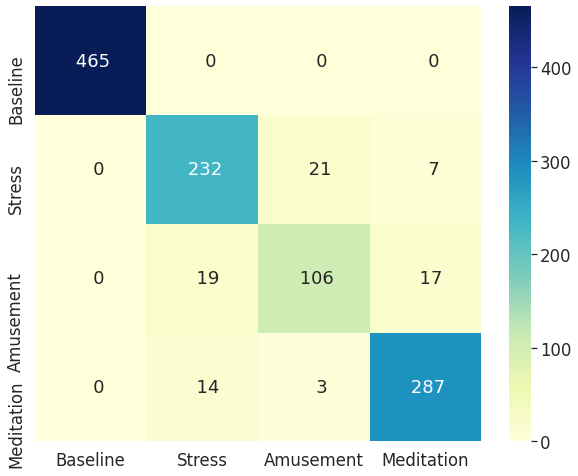

In [376]:
predicted_labels = model.predict(test_features)

confusion_matrix = np.zeros((4, 4))

for test_label, predicted_label in zip(test_labels, predicted_labels) :
    i = np.argmax(test_label)
    j = np.argmax(predicted_label)
    
    confusion_matrix[i][j] += 1
    
classes = ['Baseline', 'Stress', 'Amusement', 'Meditation']
df = pd.DataFrame(confusion_matrix, classes, classes)

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, fmt="4.0f", cmap="YlGnBu")

In [375]:
model.load_weights(checkpoint_filepath)

In [371]:
checkpoint_filepath = '../Models/DemoBest.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

In [331]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [233]:
model_checkpoint_callback.

SyntaxError: invalid syntax (<ipython-input-233-84f5a96af3a0>, line 1)